In [85]:
words = [word.lower() for word in open('first-names.txt', 'r').read().split()]
words[:5]

['aaren', 'aarika', 'abagael', 'abagail', 'abbe']

In [86]:
len(words)

4950

In [87]:
min(len(w) for w in words)

2

In [88]:
max(len(w) for w in words)

14

In [89]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
#        print(ch1, ch2)

In [90]:
#sorted(b.items(), key = lambda kv: -kv[1])

In [91]:
import torch

In [92]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [93]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [96]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

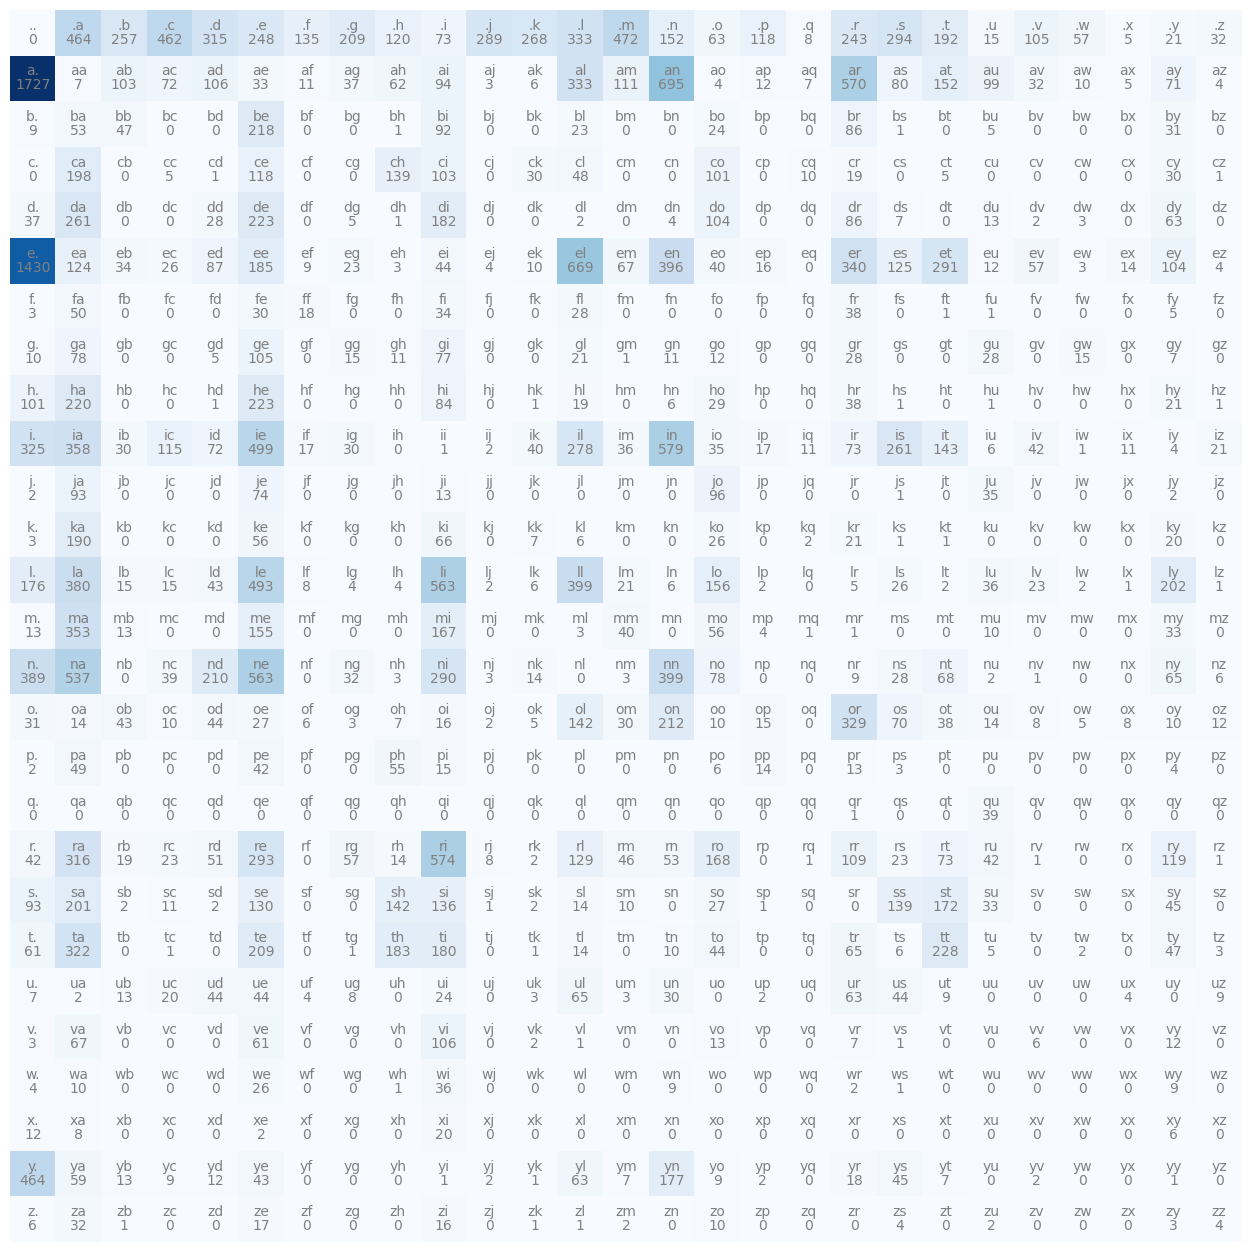

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize= (16, 16))
plt.imshow(N, cmap= 'Blues')
for i in range (27):
    for j in range(27):
        chstr = itos [i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');


In [99]:
N[0]

tensor([  0, 464, 257, 462, 315, 248, 135, 209, 120,  73, 289, 268, 333, 472,
        152,  63, 118,   8, 243, 294, 192,  15, 105,  57,   5,  21,  32],
       dtype=torch.int32)

In [125]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0937, 0.0519, 0.0933, 0.0636, 0.0501, 0.0273, 0.0422, 0.0242,
        0.0147, 0.0584, 0.0541, 0.0673, 0.0954, 0.0307, 0.0127, 0.0238, 0.0016,
        0.0491, 0.0594, 0.0388, 0.0030, 0.0212, 0.0115, 0.0010, 0.0042, 0.0065])

In [128]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [105]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [115]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([1, 1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1,
        0, 0, 1, 1])

In [141]:
p.shape

torch.Size([27])

In [177]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [178]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
canagaropallay.
a.
be.
fri.


In [182]:
log_likelihood = 0.0
n = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'({ch1}{ch2}: {prob:.4f} {logprob:.4f})')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-59.1034)
nll=tensor(59.1034)
2.814446210861206


In [183]:
#create training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. a
a a
a r
r e
e n
n .


In [184]:
xs

tensor([ 0,  1,  1, 18,  5, 14])

In [185]:
ys

tensor([ 1,  1, 18,  5, 14,  0])

In [189]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [192]:
xenc.shape

torch.Size([6, 27])

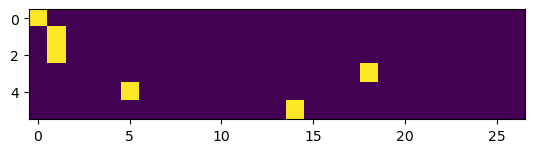

In [191]:
plt.imshow(xenc)

In [193]:
xenc.dtype

torch.float32

In [196]:
W = torch.randn((27, 27))
xenc @ W

tensor([[-1.8039e+00,  7.2705e-01,  4.9304e-01, -1.9993e-02, -3.9132e-01,
          8.8124e-01,  1.7278e-01,  4.1577e-01,  4.3730e-01,  8.9686e-01,
          5.4591e-01,  3.5457e-01, -1.4809e+00, -9.5880e-01, -4.2293e-02,
          2.4402e-01,  3.1496e-01,  2.8731e-02, -1.4193e+00, -1.2030e+00,
          1.8627e+00, -3.3455e-01, -5.8532e-01, -9.8177e-01, -1.1254e+00,
         -7.9978e-01, -1.0179e+00],
        [ 3.3664e-01,  2.0407e+00, -6.1688e-01,  9.4019e-01, -2.9446e-02,
          2.4044e+00, -2.4283e-01, -2.9961e-02, -5.1901e-01,  3.8688e-02,
         -3.9661e-01, -6.0831e-01,  4.7827e-01,  2.4093e-01,  1.9892e-01,
         -9.5468e-01,  3.2575e-01,  2.1285e-01,  9.5400e-02, -9.4937e-01,
         -5.9474e-01, -7.9712e-01,  2.0139e-01,  4.4349e-02,  3.5435e-01,
         -1.8848e+00, -6.3062e-01],
        [ 3.3664e-01,  2.0407e+00, -6.1688e-01,  9.4019e-01, -2.9446e-02,
          2.4044e+00, -2.4283e-01, -2.9961e-02, -5.1901e-01,  3.8688e-02,
         -3.9661e-01, -6.0831e-01,  4.78

In [217]:
###-------------------###
#randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27, 27), generator=g)

In [218]:
xenc = F.one_hot(xs, num_classes=27).float() # one-hot encoding of input
logits = xenc @ W # predict log counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True) # normalize to get probabilities for next character
# last two lines called softmax

In [215]:
probs.shape

torch.Size([6, 27])

In [219]:
nlls = torch.zeros (5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print("------")
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y}) ')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs [i])
    print ('label (actual next character):', y)
    p = probs [i, y]
    print('probability assigned by the net to the the correct character:', p.item ())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = - logp
    print ('negative log likelihood:', nll.item())
    nlls [i] = nll
print("======")
print('average negative log likelihood, i.e. loss =', nlls.mean ().item () )

------
bigram example 1: .a (indexes 0, 1) 
input to the neural net: 0
output probabilities from the neural net: tensor([0.0426, 0.0299, 0.0233, 0.0382, 0.0229, 0.0229, 0.0507, 0.0563, 0.0211,
        0.0280, 0.0440, 0.0313, 0.0497, 0.0439, 0.0308, 0.0261, 0.0424, 0.0563,
        0.0547, 0.0325, 0.0425, 0.0222, 0.0472, 0.0285, 0.0566, 0.0295, 0.0258])
label (actual next character): 1
probability assigned by the net to the the correct character: 0.029875433072447777
log likelihood: -3.510718822479248
negative log likelihood: 3.510718822479248
------
bigram example 2: aa (indexes 1, 1) 
input to the neural net: 1
output probabilities from the neural net: tensor([0.0402, 0.0517, 0.0303, 0.0400, 0.0258, 0.0318, 0.0394, 0.0301, 0.0308,
        0.0550, 0.0468, 0.0402, 0.0388, 0.0468, 0.0580, 0.0386, 0.0341, 0.0400,
        0.0246, 0.0336, 0.0232, 0.0235, 0.0490, 0.0309, 0.0350, 0.0253, 0.0363])
label (actual next character): 1
probability assigned by the net to the the correct character: 0.0

In [228]:
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27, 27), generator=g, requires_grad=True)

In [280]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # one-hot encoding of input
logits = xenc @ W # predict log counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True) # normalize to get probabilities for next character
loss = -probs[torch.arange(6), ys].log().mean()

In [281]:
print(loss.item())

0.24239230155944824


In [278]:
#backward pass
W.grad = None # set gradient to zero
loss.backward() # compute gradients

In [279]:
W.data += -0.1 * W.grad.data # update weights

In [282]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  35129


In [306]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # cross-entropy loss + L2 regularization
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

2.366922378540039
2.364492177963257
2.362210988998413
2.3600661754608154
2.3580477237701416
2.3561458587646484
2.354351282119751
2.3526556491851807
2.3510522842407227
2.349534511566162
2.348095655441284
2.346730947494507
2.3454341888427734
2.3442018032073975
2.343029260635376
2.341911792755127
2.3408470153808594
2.3398308753967285
2.338860273361206
2.337932825088501
2.337045907974243
2.336196184158325
2.3353829383850098
2.3346028327941895
2.3338546752929688
2.3331358432769775
2.3324456214904785
2.331782102584839
2.331143617630005
2.3305296897888184
2.3299379348754883
2.3293676376342773
2.328817844390869
2.3282876014709473
2.327775478363037
2.3272812366485596
2.32680344581604
2.3263418674468994
2.3258955478668213
2.3254635334014893
2.325045347213745
2.3246407508850098
2.3242485523223877
2.3238682746887207
2.3234996795654297
2.3231427669525146
2.322795867919922
2.3224589824676514
2.3221325874328613
2.321815013885498
2.321507215499878
2.321207284927368
2.320916175842285
2.3206331729888916

In [309]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
canagaropallay.
a.
be.
fri.
